In [1]:
import pandas as pd


train=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

c:\users\junji\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\users\junji\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


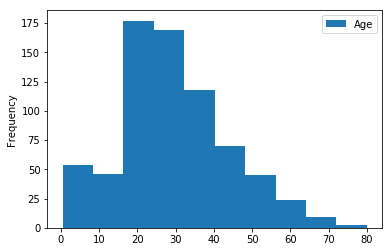

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

train.plot(kind="hist",y="Age")

In [98]:
train_copy= train.copy()
train_copy.head()
train_copy= train_copy.dropna(subset=["Embarked"])

In [99]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [100]:
# Apply function on to the pandas datafram
def determineAlone(row):
    if (row>0):
        return 1
    else :
        return 0

In [167]:
# FUNCTION THAT CAN COMBINE TWO DATAFRAMES INTO ONE DATAFRAME (EXPLICIT TO THIS DATA )
# Make a new attribute if there are alone or not
train_num = DataFrameSelector(["Pclass","Age","SibSp", "Parch", "Fare"]).transform(train_copy)
sibsp_ix , parch_ix = 2,3
import numpy as np
class CombineAttrib(BaseEstimator,TransformerMixin):
    def __init__(self,add_alone =True):
        self.add_alone=add_alone
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        family_size= X[:,sibsp_ix] + X[:,parch_ix] #this is a numpy array 
                    
        is_alone = np.where(family_size==0,family_size,1)
        return np.c_[X,is_alone]
# train_num

In [168]:
extra_attr = CombineAttrib()
titanic_extra_attrib = extra_attr.transform(train_num)
# titanic_extra_attrib

In [169]:
# Pipeline to process the numbers
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline=Pipeline([
    ('selector',DataFrameSelector(["Pclass","Age","SibSp", "Parch", "Fare"])), #this will return the values (Numerical)
    ('attrib_adder',CombineAttrib()),
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scalar',StandardScaler())
])
num_pip_tr=num_pipeline.fit_transform(train_copy)
num_pip_tr.shape

(889, 6)

In [170]:
# Imputer for string cat 
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)


In [174]:
from sklearn.preprocessing import OneHotEncoder

cat_pipe = Pipeline([
    ('selector',DataFrameSelector(["Sex","Embarked"])),
    ('cat_encoder',OneHotEncoder(sparse=False))
])
cat_pipe.fit_transform(train_copy)[1]
# train_copy.info()

array([1., 0., 1., 0., 0.])

In [175]:
# Combine the pipelines
from sklearn.pipeline import FeatureUnion

full_pipe= FeatureUnion(transformer_list=[
    ('num_pip',num_pipeline,),
    ('cat_pipeline',cat_pipe)
])

full_pipe.fit_transform(train_copy)

array([[ 0.82520863, -0.56367407,  0.43135024, ...,  0.        ,
         0.        ,  1.        ],
       [-1.57221121,  0.66921696,  0.43135024, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82520863, -0.25545131, -0.47519908, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82520863, -0.10133993,  0.43135024, ...,  0.        ,
         0.        ,  1.        ],
       [-1.57221121, -0.25545131, -0.47519908, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82520863,  0.20688282, -0.47519908, ...,  0.        ,
         1.        ,  0.        ]])

In [177]:
x_train=full_pipe.fit_transform(train_copy)
x_train.shape

(889, 11)

In [109]:
y_train=train_copy['Survived']

In [110]:
# First try use SGDClassfier 
from sklearn.linear_model import SGDClassifier

sgd_clf =SGDClassifier(random_state=42)

sgd_clf.fit(x_train,y_train)


c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [111]:
x_test = full_pipe.transform(test_data)
y_test= sgd_clf.predict(x_test)
passenger_id= test_data.PassengerId

In [112]:
# Try our cross validation to see how good the model does 
from sklearn.model_selection import cross_val_score
sgd_cross_score = cross_val_score(sgd_clf,x_train,y_train,cv=10)
sgd_cross_score.mean()
# Thus we See that SGD Classifier does not do too well

c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have

0.7042007150153216

## We Will use a random forest Classifier

Maybe it will do better that the sgd


In [113]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(x_train,y_train)

rf_cross_score = cross_val_score(rf_clf,x_train,y_train,cv=10)
rf_cross_score.mean(0)

c:\users\junji\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7975357507660878

In [123]:
acc_random_forest = round(rf_clf.score(x_train, y_train) * 100, 2)
acc_random_forest

96.4

In [114]:
# Use grid search to tune hyper parametest
from sklearn.model_selection import GridSearchCV
param_grid=[
    {'n_estimators':[10,20,30,40,50,60,70,80,100],'max_features': ["auto","sqrt","log2"],"warm_start":["True","False"]},
    {'bootstrap':["False"],'n_estimators':[10,15,25,35],"warm_start":["True","False"]}
]

_rf_clf= RandomForestClassifier(random_state=42)
grid_search =GridSearchCV(_rf_clf,param_grid,cv=5)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 100], 'max_features': ['auto', 'sqrt', 'log2'], 'warm_start': ['True', 'False']}, {'bootstrap': ['False'], 'n_estimators': [10, 15, 25, 35], 'warm_start': ['True', 'False']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [115]:
grid_search.best_params_

{'max_features': 'auto', 'n_estimators': 70, 'warm_start': 'True'}

In [126]:
final_model= grid_search.best_estimator_
final_score=cross_val_score(final_model,x_train,y_train,cv=5)
final_predictions=final_model.predict(x_test)
final_score.mean()


0.8087919761315305

In [125]:
acc_final_model = round(final_model.score(x_train, y_train) * 100, 2)
acc_final_model

97.98

In [134]:
# Plot final model , Might be off the charts
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curve(model,x,y):
    x_t,x_v,y_t,y_v = train_test_split(x,y,test_size=0.2)
    train_err, val_err=[],[]
    for m in range(1,len(x_t)):
        model.fit(x_t[:m],y_t[:m])
        y_t_pred= model.predict(x_t[:m])
        y_val_pred=model.predict(x_v)
        
        train_err.append(mean_squared_error(y_t[:m],y_t_pred))
        val_err.append(mean_squared_error(y_v,y_val_pred))
    plt.plot(np.sqrt(train_err),"r-+",linewidth=2,label="train")
    plt.plot(np.sqrt(val_err),"b-",linewidth=2,label="val")

c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


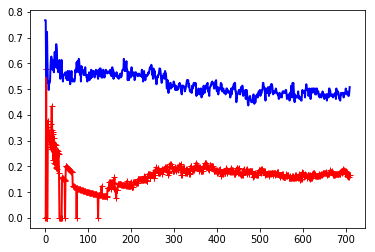

In [156]:
random_for = RandomForestClassifier(random_state=42)

plot_learning_curve(random_for,x_train,y_train)
# x_t,x_v,y_t,y_v = train_test_split(x_train,y_train,test_size=0.2)

In [128]:
# WRITE TO CSV
submission = pd.DataFrame({
        "PassengerId": passenger_id,
        "Survived": final_predictions
    })

submission.to_csv("submission.csv",index=False)

# Here we will use a k_neightbours_ classifier


In [118]:
from sklearn.neighbors import KNeighborsClassifier

kn_clf= KNeighborsClassifier()

kn_clf.fit(x_train,y_train)
kn_predictions= kn_clf.predict(x_test)

In [119]:
cross_val_score(kn_clf,x_train,y_train,cv=10).mean()

0.8042517875383043

## Decision Tree


In [120]:
from sklearn.tree import DecisionTreeClassifier

dt_clf= DecisionTreeClassifier(random_state=42)
cross_val_score(dt_clf,x_train,y_train,cv=10).mean()

0.7806945863125639

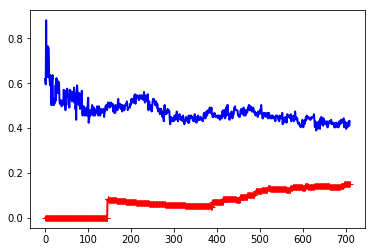

In [158]:
dt_eval = DecisionTreeClassifier()
plot_learning_curve(dt_eval,x_train,y_train)

## Using a logistic regressor Classification


In [121]:
from sklearn.linear_model import LogisticRegression
log_clf= LogisticRegression(random_state=42)

cross_val_score(log_clf,x_train,y_train,cv=10).mean()


c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\junji\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\junji\appdata\local\programs\python\python37\lib\si

0.7975740551583248